In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model


from matplotlib.offsetbox import OffsetImage, AnnotationBbox

PATH = Path('../..').resolve()

seed = 12345

%matplotlib inline

In [2]:
sys.path.append(f'{PATH}/src')

from mxresnet import *
from ranger import Ranger

slope = lambda y, p: ((y-y.mean())*(p-p.mean())).sum()/((y-y.mean())**2).sum()

Mish activation loaded...
Mish activation loaded...


In [3]:
xGASS_stats = [tensor([-0.0169, -0.0105, -0.0004]), tensor([0.9912, 0.9968, 1.0224])]

tfms = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_zoom=1.0,
    max_rotate=15.0,
    max_lighting=0,
    max_warp=0,
)

In [4]:
df = pd.read_csv(f"{PATH}/data/a40-SDSS_gas-frac.csv")

src = (
    ImageList.from_df(
        df, path=PATH, folder="images-OC", suffix=".jpg", cols="AGCNr"
    )
    .split_by_rand_pct(0.2, seed=seed)
    .label_from_df(cols=["logfgas"], label_cls=FloatList)
)

data = (
    src.transform(tfms, size=224)
    .databunch(bs=32)
    .normalize(xGASS_stats)
)

model = mxresnet50()
model[-1] = nn.Linear(model[-1].in_features, 1, bias=True)

In [5]:
learn = Learner(
    data,
    model=model,
    opt_func=partial(Ranger),
    loss_func=root_mean_squared_error,
    wd=1e-3,
    bn_wd=False,
    true_wd=True,
)

In [6]:
learn = learn.load('best_a40A-50');

set state called


In [7]:
m = learn.model.eval();

# Defining a confidence parameter (using only ALFALFA)

## Fetch trained PCA + activations from notebook **40**

In [66]:
with open(f'{PATH}/results/confidence/PCA-model_train_acts-a40.pkl', 'rb') as f:
    pca = pickle.load(f)

In [67]:
train_acts_PCA = np.load(f'{PATH}/results/confidence/train_acts_PCA-a40.npy')
valid_acts_PCA = np.load(f'{PATH}/results/confidence/valid_acts_PCA-a40.npy')

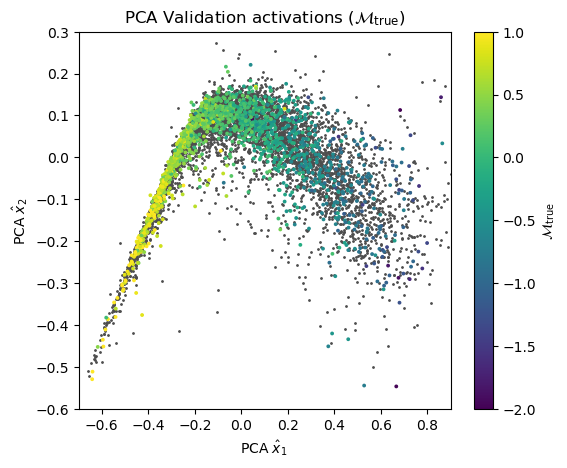

In [68]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(train_acts_PCA[:, 0], train_acts_PCA[:, 1], c='0.3', s=1)

plt.scatter(valid_acts_PCA[:, 0], valid_acts_PCA[:, 1], c=data.valid_ds.y.items, vmin=-2, vmax=1, s=3)

cb = plt.colorbar()

plt.title(f'PCA Validation activations ' r'($\mathcal{M}_{\rm true}$)')
cb.set_label(r'$\mathcal{M}_{\rm true}$')
plt.xlabel(r'PCA $\hat x_1$')
plt.ylabel(r'PCA $\hat x_2$')

plt.xlim(-0.7, 0.9)
plt.ylim(-0.6, 0.3)

plt.show()


In [69]:
lm = linear_model.LinearRegression()

X = train_acts_PCA[:, 0]
y = train_acts_PCA[:, 1]

lm.fit(X[X < -0.2].reshape((-1,1)), y[X < -0.2])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [70]:
def f(x): return np.array(x)*lm.coef_[0] + lm.intercept_

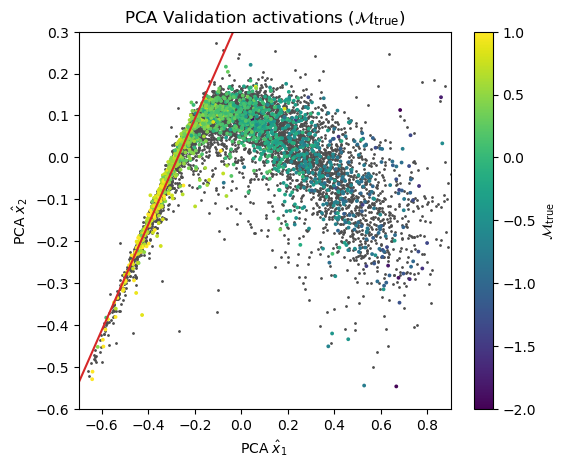

In [71]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(train_acts_PCA[:, 0], train_acts_PCA[:, 1], c='0.3', s=1)

plt.scatter(valid_acts_PCA[:, 0], valid_acts_PCA[:, 1], c=data.valid_ds.y.items, vmin=-2, vmax=1, s=3)

cb = plt.colorbar()

plt.title(f'PCA Validation activations ' r'($\mathcal{M}_{\rm true}$)')
cb.set_label(r'$\mathcal{M}_{\rm true}$')
plt.xlabel(r'PCA $\hat x_1$')
plt.ylabel(r'PCA $\hat x_2$')


plt.plot([-1, 1], f([-1, 1]), c='C3')

plt.xlim(-0.7, 0.9)
plt.ylim(-0.6, 0.3)

plt.show()


In [72]:
def distance_to_lm(x0, y0, lm=lm):
    a, b, c = lm.coef_[0], -1, lm.intercept_
    return np.abs(a*x0 + b*y0 + c) / np.sqrt(a**2 + b**2)

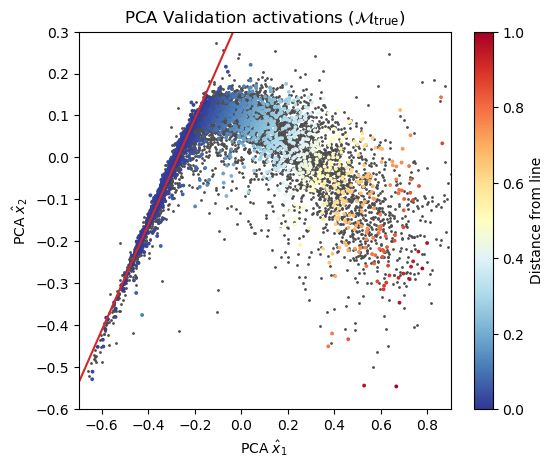

In [73]:
dists = distance_to_lm(valid_acts_PCA[:, 0], valid_acts_PCA[:, 1], lm=lm)

plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(train_acts_PCA[:, 0], train_acts_PCA[:, 1], c='0.3', s=1)

plt.scatter(valid_acts_PCA[:, 0], valid_acts_PCA[:, 1], c=dists, s=3, cmap='RdYlBu_r', vmin=0, vmax=1)

cb = plt.colorbar()

plt.title(f'PCA Validation activations ' r'($\mathcal{M}_{\rm true}$)')
cb.set_label(r'Distance from line')
plt.xlabel(r'PCA $\hat x_1$')
plt.ylabel(r'PCA $\hat x_2$')


plt.plot([-1, 1], f([-1, 1]), c='C3')

plt.xlim(-0.7, 0.9)
plt.ylim(-0.6, 0.3)

plt.show()


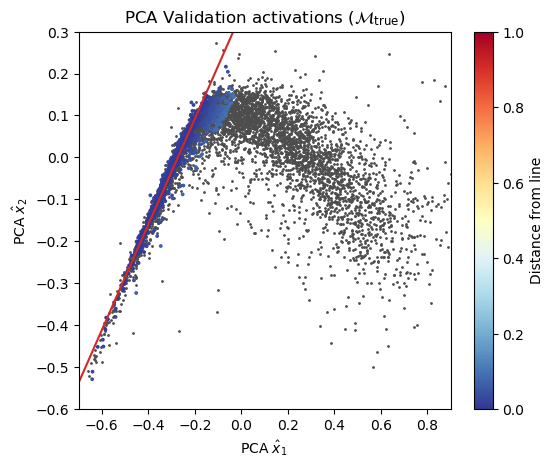

In [74]:
# make cut with distance < 0.1
within_dist = dists < 0.1


plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(train_acts_PCA[:, 0], train_acts_PCA[:, 1], c='0.3', s=1)

plt.scatter(valid_acts_PCA[within_dist][:, 0], valid_acts_PCA[within_dist][:, 1], c=dists[within_dist], s=3, cmap='RdYlBu_r', vmin=0, vmax=1)

cb = plt.colorbar()

plt.title(f'PCA Validation activations ' r'($\mathcal{M}_{\rm true}$)')
cb.set_label(r'Distance from line')
plt.xlabel(r'PCA $\hat x_1$')
plt.ylabel(r'PCA $\hat x_2$')


plt.plot([-1, 1], f([-1, 1]), c='C3')

plt.xlim(-0.7, 0.9)
plt.ylim(-0.6, 0.3)

plt.show()


# Use validation set to see how dist cutout varies with RMSE

In [75]:
def rmse(p,y): return np.mean((p-y)**2)**0.5

In [76]:
res = pd.read_csv(f'{PATH}/results/predictions/best_a40A-50.csv')

In [82]:
scores = []
cutoffs = np.arange(0.05, 0.25, 0.01)

for cutoff in cutoffs:
    within_dist = dists < cutoff
    score = rmse(res[within_dist].fgas_pred, res[within_dist].fgas_true)
    scores.append(score)

Text(0, 0.5, 'RMSE (dex)')

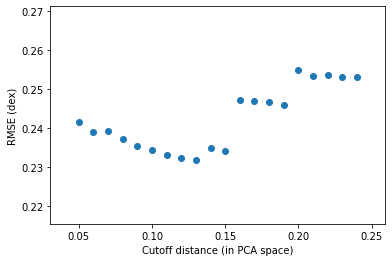

In [83]:
plt.scatter(cutoffs, scores)
plt.xlabel('Cutoff distance (in PCA space)')
plt.ylabel('RMSE (dex)')

According to this metric, we'd expect a cutoff below 0.13 to work well.

# Test with NIBLES (similar input distribution space)

## Visualize cutoff in PCA space

In [84]:
nibles = pd.read_csv(f'{PATH}/data/NIBLES_clean.csv')
nibles = nibles[(nibles.logMstar > 8) & np.isfinite(nibles.logfgas)].copy()

nible_ids = np.array([p.stem for p in list(PATH.glob(pattern='images-nibles_cleaned/*.jpg'))], dtype=int)

nibles.set_index('nibles_id', inplace=True)
nibles.drop([obj for obj in nibles.index if obj not in nible_ids], inplace=True)
nibles.reset_index(inplace=True)

In [85]:
nibles_data = (
    ImageList.from_df(nibles, path=PATH, folder="images-nibles_cleaned", suffix=".jpg", cols="nibles_id")
        .split_none()
        .label_from_df(cols=["logfgas"], label_cls=FloatList)
    .transform(tfms, size=224)
    .databunch(bs=32)
    .normalize(xGASS_stats)
)

In [86]:
learn.data.valid_dl = nibles_data.train_dl

In [87]:
N_nibles = len(data.valid_ds)


nibles_acts = np.zeros(shape=(N_nibles, 2048))

# grab all activations for training set
for i, fn in tqdm(enumerate(data.valid_dl.items), total=N_nibles):
    img = open_image(fn);
        
    # get single item
    X, _ = data.one_item(img)
    
    # save activations before final linear layer
    with hook_output(model[-2]) as hook_a:
        pred = m(X.cuda())
    
        nibles_acts[i] = hook_a.stored[0].cpu().numpy()

In [88]:
nibles_acts_PCA = pca.transform(nibles_acts)

# np.save(f'{PATH}/results/confidence/nibles_acts_PCA-combined.npy', nibles_acts_PCA)

In [89]:
dists = distance_to_lm(nibles_acts_PCA[:, 0], nibles_acts_PCA[:, 1], lm=lm)

within_dist = dists < 0.13

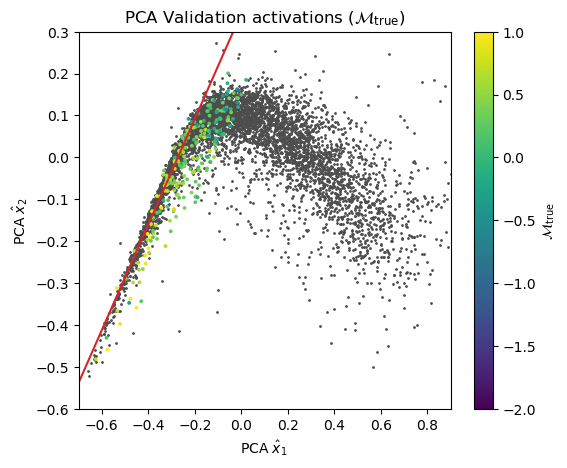

In [90]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(train_acts_PCA[:, 0], train_acts_PCA[:, 1], c='0.3', s=1)

plt.scatter(nibles_acts_PCA[within_dist][:, 0], nibles_acts_PCA[within_dist][:, 1], c=nibles.logfgas[within_dist], vmin=-2, vmax=1, s=3)

cb = plt.colorbar()

plt.title(f'PCA Validation activations ' r'($\mathcal{M}_{\rm true}$)')
cb.set_label(r'$\mathcal{M}_{\rm true}$')
plt.xlabel(r'PCA $\hat x_1$')
plt.ylabel(r'PCA $\hat x_2$')


plt.plot([-1, 1], f([-1, 1]), c='C3')

plt.xlim(-0.7, 0.9)
plt.ylim(-0.6, 0.3)

plt.show()


## get preds

In [91]:
nibles_preds = pd.read_csv(f'{PATH}/results/nibles/nibles_clean_results.csv', index_col=0) 

In [92]:
rmse(nibles_preds[within_dist].fgas_pred, nibles_preds[within_dist].fgas_true)

0.3595079736897802

# Test with xGASS

In [93]:
xg = pd.read_csv(f"{PATH}/data/xGASS_representative_sample.csv")

data_xg = (
        ImageList.from_df(
            xg, path=PATH, folder="images-xGASS", suffix=".jpg", cols="GASS"
        )
        .split_none()
        .label_from_df(cols=["lgGF"], label_cls=FloatList)
    .transform(tfms, size=224)
    .databunch(bs=32)
    .normalize(xGASS_stats)
)


In [94]:
N_xg = len(data_xg.train_ds)


xg_acts = np.zeros(shape=(N_xg, 2048))

# grab all activations for training set
for i, fn in tqdm(enumerate(data_xg.train_dl.items), total=N_xg):
    img = open_image(fn);
        
    # get single item
    X, _ = data_xg.one_item(img)
    
    # save activations before final linear layer
    with hook_output(model[-2]) as hook_a:
        pred = m(X.cuda())
    
        xg_acts[i] = hook_a.stored[0].cpu().numpy()

In [95]:
xg_acts_PCA = pca.transform(xg_acts)


In [96]:
dists = distance_to_lm(xg_acts_PCA[:, 0], xg_acts_PCA[:, 1], lm=lm)

within_dist = dists < 0.13

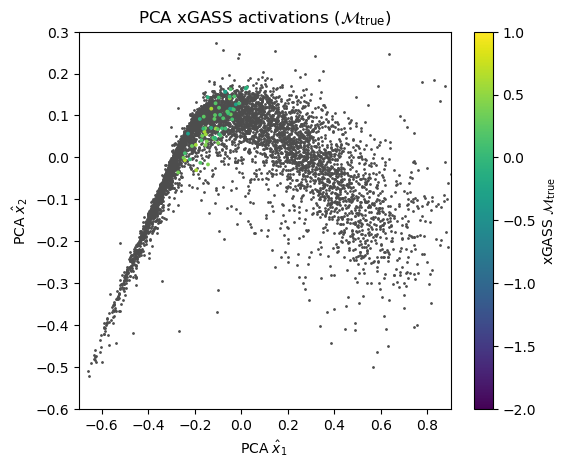

In [98]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(train_acts_PCA[:, 0], train_acts_PCA[:, 1], c='0.3', s=1)

plt.scatter(xg_acts_PCA[within_dist][:, 0], xg_acts_PCA[within_dist][:, 1], c=data_xg.train_ds.y.items[within_dist], vmin=-2, vmax=1, s=3)

cb = plt.colorbar()

plt.title(f'PCA xGASS activations ' r'($\mathcal{M}_{\rm true}$)')
cb.set_label(r'xGASS $\mathcal{M}_{\rm true}$')
plt.xlabel(r'PCA $\hat x_1$')
plt.ylabel(r'PCA $\hat x_2$')

plt.xlim(-0.7, 0.9)
plt.ylim(-0.6, 0.3)

plt.show()


In [104]:
xg_results = np.zeros((len(data_xg.train_ds), 2))

for i, [x,y] in tqdm(enumerate(data_xg.train_ds), total=len(xg_results)):
    p = learn.predict(x)[0]
    xg_results[i] = [float(p.data[0]), float(y.data)]

In [106]:
sum(within_dist)

60

In [105]:
rmse(xg_results[within_dist][:, 0], xg_results[within_dist][:, 1])

0.22806973280408788

# Check hyperparam -- note these tests are done after previous hyperparam (dist < 0.13 was set)

In [109]:
xg_results

array([[-0.64861 , -1.106   ],
       [-0.768167, -1.799   ],
       [-0.703346, -1.381   ],
       [-0.483706, -1.458   ],
       ...,
       [-0.943582, -1.508   ],
       [-0.939659, -1.177   ],
       [-0.588747, -0.769   ],
       [-0.46668 , -0.733   ]])

In [110]:
nibles_scores = []
xgass_scores = []

for cutoff in cutoffs:
    dists_nibles = distance_to_lm(nibles_acts_PCA[:, 0], nibles_acts_PCA[:, 1], lm=lm)
    dists_xgass = distance_to_lm(xg_acts_PCA[:, 0], xg_acts_PCA[:, 1], lm=lm)

    
    within_dist_nibles = dists_nibles < cutoff
    within_dist_xgass = dists_xgass < cutoff

    nibles_scores.append(rmse(nibles_preds[within_dist_nibles].fgas_pred, nibles_preds[within_dist_nibles].fgas_true))
    xgass_scores.append(rmse(xg_results[within_dist_xgass][:, 0], xg_results[within_dist_xgass][:, 1]))

Text(0, 0.5, 'RMSE (dex)')

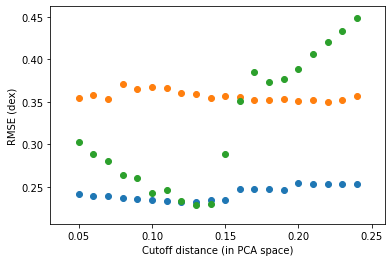

In [111]:
plt.scatter(cutoffs, scores)
plt.scatter(cutoffs, nibles_scores)
plt.scatter(cutoffs, xgass_scores)


plt.xlabel('Cutoff distance (in PCA space)')
plt.ylabel('RMSE (dex)')

## Check std (*not* RMSE)

In [112]:
scatters = []
nibles_scatters = []
xgass_scatters = []

for cutoff in cutoffs:
    dists = distance_to_lm(valid_acts_PCA[:, 0], valid_acts_PCA[:, 1], lm=lm)
    dists_nibles = distance_to_lm(nibles_acts_PCA[:, 0], nibles_acts_PCA[:, 1], lm=lm)
    dists_xgass = distance_to_lm(xg_acts_PCA[:, 0], xg_acts_PCA[:, 1], lm=lm)

    within_dist = dists < cutoff
    within_dist_nibles = dists_nibles < cutoff
    within_dist_xgass = dists_xgass < cutoff

    scatters.append(np.std(res[within_dist].fgas_pred - res[within_dist].fgas_true))
    nibles_scatters.append(np.std(nibles_preds[within_dist_nibles].fgas_pred - nibles_preds[within_dist_nibles].fgas_true))
    xgass_scatters.append(np.std(xg_results[within_dist_xgass][:, 0] - xg_results[within_dist_xgass][:, 1]))
    


Text(0, 0.5, 'RMSE (dex)')

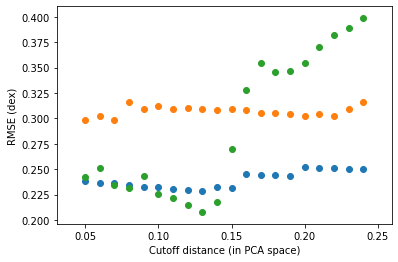

In [113]:
plt.scatter(cutoffs, scatters)
plt.scatter(cutoffs, nibles_scatters)
plt.scatter(cutoffs, xgass_scatters)


plt.xlabel('Cutoff distance (in PCA space)')
plt.ylabel('RMSE (dex)')

# Examine ALFALFA + xGASS trained model (experiment)

In [8]:
learn.load('combined-mxresnet50-fc_80ep');

set state called


## Get activations

In [ ]:
N_train = len(data.train_ds)


train_acts = np.zeros(shape=(N_train, 2048))

# grab all activations for training set
for i, fn in tqdm(enumerate(data.train_dl.items), total=N_train):
    img = open_image(fn);
        
    # get single item
    X, _ = data.one_item(img)
    
    # save activations before final linear layer
    with hook_output(model[-2]) as hook_a:
        pred = m(X.cuda())
    
        train_acts[i] = hook_a.stored[0].cpu().numpy()

In [ ]:
N_valid = len(data.valid_ds)


valid_acts = np.zeros(shape=(N_valid, 2048))

# grab all activations for training set
for i, fn in tqdm(enumerate(data.valid_dl.items), total=N_valid):
    img = open_image(fn);
        
    # get single item
    X, _ = data.one_item(img)
    
    # save activations before final linear layer
    with hook_output(model[-2]) as hook_a:
        pred = m(X.cuda())
    
        valid_acts[i] = hook_a.stored[0].cpu().numpy()

## Examine validation high-level (PCA) feature vectors

In [10]:
pca = PCA(n_components=10, random_state=seed)
# train_acts_PCA = pca.fit_transform(train_acts)

# np.save(f'{PATH}/results/confidence/train_acts_PCA-combined.npy', train_acts_PCA)
train_acts_PCA = np.load(f'{PATH}/results/confidence/train_acts_PCA-combined.npy')

In [11]:
# with open(f'{PATH}/results/confidence/PCA-model_train_acts-combined.pkl', 'wb') as f:
#     pickle.dump(pca, f)

with open(f'{PATH}/results/confidence/PCA-model_train_acts-combined.pkl', 'rb') as f:
    pca = pickle.load(f)

In [12]:
# valid_acts_PCA = pca.transform(valid_acts)

# np.save(f'{PATH}/results/confidence/valid_acts_PCA-combined.npy', valid_acts_PCA)
valid_acts_PCA = np.load(f'{PATH}/results/confidence/valid_acts_PCA-combined.npy')

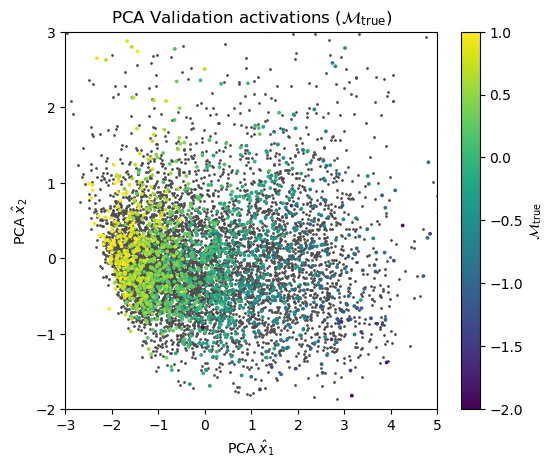

In [30]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(train_acts_PCA[:, 0], train_acts_PCA[:, 1], c='0.3', s=1)

plt.scatter(valid_acts_PCA[:, 0], valid_acts_PCA[:, 1], c=data.valid_ds.y.items, vmin=-2, vmax=1, s=3)

cb = plt.colorbar()

plt.title(f'PCA Validation activations ' r'($\mathcal{M}_{\rm true}$)')
cb.set_label(r'$\mathcal{M}_{\rm true}$')
plt.xlabel(r'PCA $\hat x_1$')
plt.ylabel(r'PCA $\hat x_2$')

plt.xlim(-3, 5)
plt.ylim(-2, 3)

plt.show()


This is interesting-- there is no longer any bimodality here. This means that a single (very non-linear!) morphological relation can handle both red+dead and blue star-forming galaxies!

## Check residuals

In [25]:
results = np.zeros((len(learn.data.valid_ds), 2))

for i, [x,y] in tqdm(enumerate(learn.data.valid_ds), total=len(results)):
    p = learn.predict(x)[0]
    results[i] = [float(p.data[0]), float(y.data)]

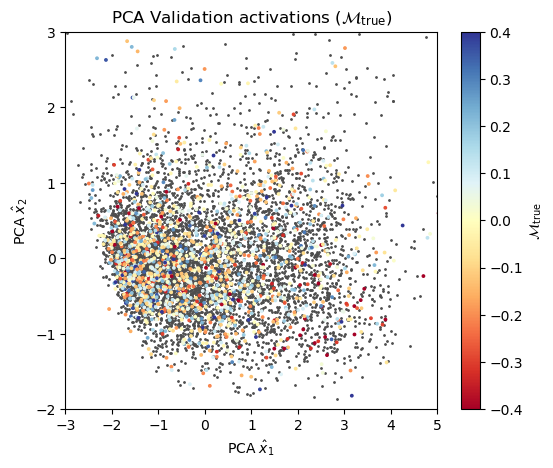

In [29]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(train_acts_PCA[:, 0], train_acts_PCA[:, 1], c='0.3', s=1)

plt.scatter(valid_acts_PCA[:, 0], valid_acts_PCA[:, 1], c=results[:, 0]-results[:, 1], vmin=-0.4, vmax=0.4, s=3, cmap='RdYlBu')

cb = plt.colorbar()

plt.title(f'PCA Validation activations ' r'($\mathcal{M}_{\rm true}$)')
cb.set_label(r'$\mathcal{M}_{\rm true}$')
plt.xlabel(r'PCA $\hat x_1$')
plt.ylabel(r'PCA $\hat x_2$')

plt.xlim(-3, 5)
plt.ylim(-2, 3)

plt.show()


In [73]:
from scipy.stats import binned_statistic_2d

res = binned_statistic_2d(
    valid_acts_PCA[:, 0], valid_acts_PCA[:, 1], results[:, 0]-results[:, 1], 
    statistic='median', bins=16, range=[[-3, 5], [-2, 3]]
)

(-2, 3)

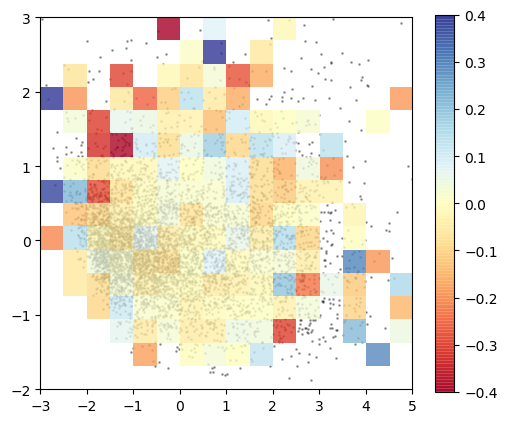

In [74]:
plt.figure(figsize=(6, 5), dpi=100)
plt.scatter(train_acts_PCA[:, 0], train_acts_PCA[:, 1], c='k', s=1, Zorder=0, alpha=0.3)

plt.imshow(
    res.statistic, vmin=-0.4, vmax=0.4, origin='lower', cmap='RdYlBu', 
    extent=[res.x_edge[0], res.x_edge[-1], res.y_edge[0], res.y_edge[-1]],
    aspect=8/5, alpha=0.8
)
plt.colorbar()

plt.xlim(-3, 5)
plt.ylim(-2, 3)


It looks like we can define a simple ball in PCA space that would remove outliers. Let's also look at other PCs via a corner plot

## Going beyond the first two PCs

In [77]:
d_logfgas = results[:, 0]-results[:, 1]

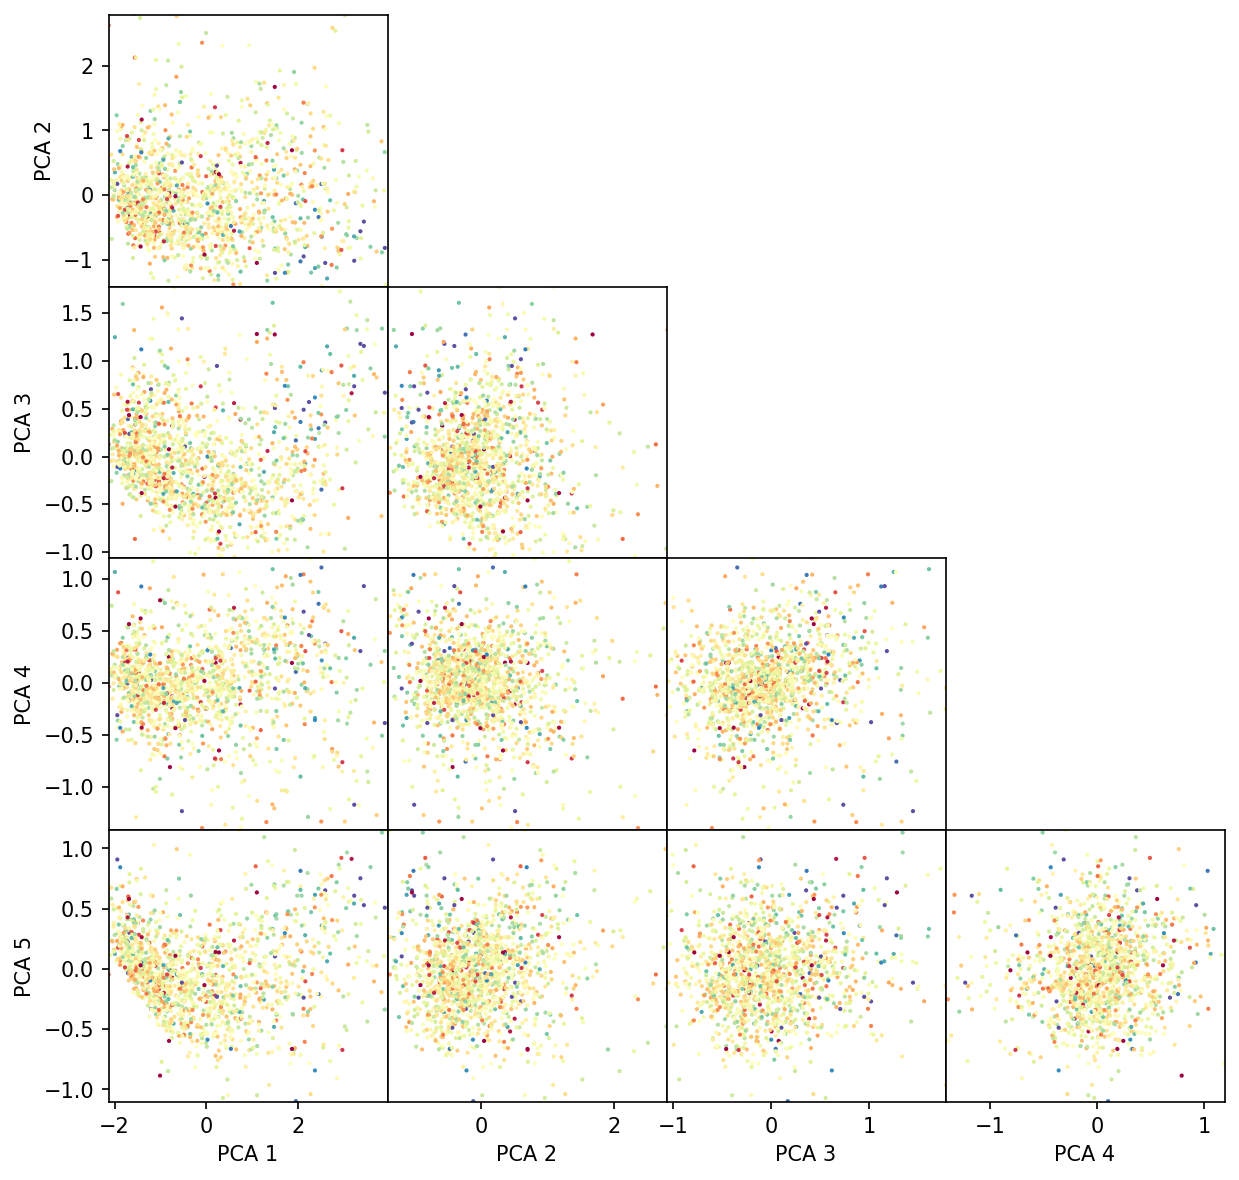

In [86]:
fig = plt.figure(figsize=(12, 12), dpi=150)
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(5):
    for j in range(5):
        if i < j:
            plt.subplot(5,5,i+j*5+1)
            if i == 0 and j != 0:
                plt.ylabel(f'PCA {j+1}')
            if j == 4:
                plt.xlabel(f'PCA {i+1}')
            if i != 0:
                plt.yticks([])
            if j != 4:
                plt.xticks([])
                
            
            xlim = np.quantile(valid_acts_PCA[:,i], [0.01, 0.99])
            ylim = np.quantile(valid_acts_PCA[:,j], [0.01, 0.99])
            


#             plt.scatter(train_acts_PCA[:,i], train_acts_PCA[:,j], s=1, marker='.', c='k', alpha=0.3)
            plt.scatter(valid_acts_PCA[:, i], valid_acts_PCA[:, j], c=d_logfgas, vmin=-0.6, vmax=0.6, s=1, cmap='Spectral_r')

#             res = binned_statistic_2d(
#                 valid_acts_PCA[:, i], valid_acts_PCA[:, j], d_logfgas, 
#                 statistic='median', bins=16, range=[[*xlim], [*ylim]]
#             )
# 
#             plt.imshow(
#                 res.statistic, vmin=-0.4, vmax=0.4, origin='lower', cmap='RdYlBu', 
#                 extent=[res.x_edge[0], res.x_edge[-1], res.y_edge[0], res.y_edge[-1]],
#                 aspect=(xlim[1]-xlim[0])/(ylim[1]-ylim[0]), alpha=0.8
#             ) 
            
            plt.xlim(*xlim)
            plt.ylim(*ylim)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()



Neat-- no structure in here! That means that the residuals don't systematically vary with our high-level representation of morphological parameter.